In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from glob import glob
from typing import List, Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dill

from maze_io import load_maze, string_maze, add_padding
from maze_env import MazeEnv, MazeAction
from astar_agent import AstarAgent, manhattan, euclid, zero_heuristic
from navmesh_agent import NavmeshAgent
from agent_utils import Stats
from general_utils import get_optimal_path_length

# Run experiments
Experiments are run to create an overall dataframe containing them all.

Running experiments with the A* agent can take <span style="color:red">over 2h of time</span>.

If the dataframe is available as a <span style="color:red">csv file</span>,
 skip to <span style="color:green">Statistics</span> section.

In [4]:
def run_single_maze(start_loc, exit_loc, maze, agentClass, heuristic, agent_verbose=False) -> Stats:
    env = MazeEnv(start_loc, exit_loc, maze)
    agent = agentClass(env, heuristic=heuristic, verbose=agent_verbose)
    agent.run()
    return agent.statistics

def prepare_maze_from_file(path):
    with path.open(mode='r') as f:
        padded_maze_tuple = add_padding(*load_maze(f))
    return padded_maze_tuple

In [2]:
n_times = 100  # how many times to repeat each maze-agent settings combination

We assume that all maze files are contained in a 'mazes' directory
which is in the same folder as this notebook file.

In [3]:
inpaths = list(map(Path, glob('./mazes/*.txt')))
maze_names = [path.stem for path in inpaths]

### Run A* Agent experiments
<span style="color:red">Beware</span>, takes a very long time (2h+)

In [5]:
def run_a_star_experiments(each_n_times: int,
                           inpaths: List[Path],
                           numpy_seed=123,
                           save_to_file=False) -> dict:
    """
    Function for running A* experiments for all heuristics (None, Euclidean dist, Manhattan dist)
    :param each_n_times: How many times to run each maze/heuristic combination
    :param inpaths: List of paths to each maze file
    :param numpy_seed: The same seed is used before running each maze/heuristic combination each_n_times times,
     so that different agents experience the same environment behaviour over the experiments.
    :param save_to_file: Whether to save the resulting dictionary to file
    :return: A nested dictionary with results,
     examine the function to see structure,
     but it is recommended to just use the following function
     to transform output of this function into a DataFrame
    """
    data = {}
    heuristics = {'None': zero_heuristic,
                  'Euclid': euclid,
                  'Manhattan': manhattan}
    for maze_num, path in enumerate(inpaths, start=1):
        maze_name = path.stem
        maze_data = prepare_maze_from_file(path)
        optimal_length = get_optimal_path_length(*maze_data)
        data[maze_name] = {"optimal": optimal_length}

        for heuristic_name, heuristic in heuristics.items():
            print(f'\r#{maze_num}/{len(inpaths)}: {maze_name} | {heuristic_name}         ', end="")
            np.random.seed(numpy_seed)
            data[maze_name][heuristic_name] = [run_single_maze(*maze_data,
                                                               AstarAgent,
                                                               heuristic=heuristic,
                                                               agent_verbose=False)
                                               for _ in range(each_n_times)]

    if save_to_file:
        with open('./a_star_dict_data.dill', mode='wb') as f:
            dill.dump(data, f)

    print("\nDone")
    return data


In [14]:
load_astar_from_file = True  # if false, compute them
if load_astar_from_file:
    with open('./a_star_dict_data.dill', mode='rb') as f:
        astar_data = dill.load(f)
else:
    astar_data = run_a_star_experiments(n_times, inpaths, save_to_file=False)

### Create partial dataframe containg A* experiments

In [15]:
def create_dataframe_from_a_star_dict(astar_data: dict, maze_names: List[str]) -> pd.DataFrame:
    dfs = []
    for name in maze_names:
        cur_opt = astar_data[name]["optimal"]
        for heur, cur_stats in astar_data[name].items():
            if heur != "optimal":
                tuplized = [(np.sum(stats.expanded_nodes),
                             stats.replan_count,
                             stats.steps)
                            for stats in cur_stats]
                cur_expanded, cur_replans, cur_steps = zip(*tuplized)
                cur_dict = {"maze": name,
                            "heuristic": heur,
                            "optimal_steps": cur_opt,
                            "steps_taken": cur_steps,
                            "expanded_nodes": cur_expanded,
                            "replan_count": cur_replans}
                dfs.append(pd.DataFrame(cur_dict))
    df = pd.concat(dfs, ignore_index=True)
    df["maze"] = df["maze"].astype('category')
    df["heuristic"] = df["heuristic"].astype('category')
    return df

In [16]:
astar_df = create_dataframe_from_a_star_dict(astar_data, maze_names)

### Run Navmesh agent experiments
Is fairly quick, under a minute

In [7]:
def run_navmesh_experiments(each_n_times: int, inpaths: List[Path], numpy_seed=123) -> Tuple[dict, dict]:
    data_navmesh = {}
    optimal_paths = {}
    for maze_num, path in enumerate(inpaths, start=1):
        maze_name = path.stem
        maze_data = prepare_maze_from_file(path)
        optimal_length = get_optimal_path_length(*maze_data)
        optimal_paths[maze_name] = optimal_length
        print(f'\r#{maze_num}/{len(inpaths)}: {maze_name}         ', end="")
        np.random.seed(numpy_seed)
        data_navmesh[maze_name] = [run_single_maze(*maze_data, NavmeshAgent, heuristic=None, agent_verbose=False)
                                   for _ in range(each_n_times)]
    print("\nDone")
    return data_navmesh, optimal_paths

In [8]:
navmesh_data_tuple = run_navmesh_experiments(n_times, inpaths)

#25/25: maze-7-5          
Done


### Create partial dataframe containg Navmesh agent experiments

In [9]:
def create_dataframe_from_navmesh_dict(navmesh_data_dict: dict, optimal_pathlen_dict: dict, maze_names: List[str]) -> pd.DataFrame:
    dataframes = []
    for name in maze_names:
        cur_maze_stats = navmesh_data_dict[name]
        cur_opt = optimal_pathlen_dict[name]
        tuplized = [(np.sum(stats.expanded_nodes),
                     1,
                     stats.steps) for stats in cur_maze_stats]
        cur_expanded, cur_replans, cur_steps = zip(*tuplized)
        cur_dict = {"maze": name,
                    "optimal_steps": cur_opt,
                    "steps_taken": cur_steps,
                    "expanded_nodes": cur_expanded,
                    "replan_count": cur_replans}
        dataframes.append(pd.DataFrame(cur_dict))
    df = pd.concat(dataframes, ignore_index=True)
    df["maze"] = df["maze"].astype('category')
    return df

In [10]:
nav_df = create_dataframe_from_navmesh_dict(*navmesh_data_tuple, maze_names)

### Create overall dataframe

In [11]:
def create_everything_dataframe(navmesh_df: pd.DataFrame, astar_df: pd.DataFrame) -> pd.DataFrame:
    nav_df_copy = navmesh_df.copy()
    nav_df_copy['heuristic'] = "Navmesh"
    all_df = pd.concat([astar_df, nav_df_copy], ignore_index=True)
    all_df.rename(columns={"heuristic": "agent"}, inplace=True)
    all_df.agent = all_df.agent.astype('category')
    all_df.agent.cat.rename_categories({"None": "Dijkstra",
                                        "Manhattan": "A*Manhattan",
                                        "Euclid": "A*Euclid"},
                                       inplace=True)
    return all_df

In [17]:
all_df = create_everything_dataframe(nav_df, astar_df)

#### Save dataframe with all experiments to csv

In [251]:
all_df.to_csv("all_experiments_dataframe.csv", index=False)

# Statistics

#### Read all experiments csv

In [21]:
all_df = pd.read_csv("all_experiments_dataframe.csv", dtype={"maze": "category", "agent": "category"})

In [22]:
# reorder categories for better plots
all_df.agent.cat.reorder_categories(["A*Euclid", "A*Manhattan", "Navmesh", "Dijkstra"], inplace=True)

In [23]:
all_df_sizes = all_df.assign(maze_size=all_df.maze.str.extract(pat='-([0-9]{1,2})-').astype(int))

### Overall statistics

In [24]:
overall_stats_df = all_df_sizes.groupby(['maze_size', 'agent'], observed=True).agg(optimal_steps=('optimal_steps', max),
                                      min_steps=('steps_taken', min),
                                      mean_steps=('steps_taken', np.mean),
                                      max_steps=('steps_taken', max),
                                      std_steps=('steps_taken', np.std),
                                      min_expanded=('expanded_nodes', min),
                                      mean_expanded=('expanded_nodes', np.mean),
                                      max_expanded=('expanded_nodes', max),
                                      std_expanded=('expanded_nodes', np.std),
                                      min_plan=('replan_count', min),
                                      mean_plan=('replan_count', np.mean),
                                      max_plan=('replan_count', max),
                                      std_plan=('replan_count', np.std))
overall_stats_df

optimal_steps  min_steps  mean_steps  max_steps  \
maze_size agent                                                          
3         Dijkstra                10         10      18.162         40   
          A*Euclid                10         10      18.270         40   
          A*Manhattan             10         10      18.162         40   
          Navmesh                 10         10      18.162         40   
7         Dijkstra                30         28      49.870         92   
          A*Euclid                30         29      48.528         84   
          A*Manhattan             30         28      49.724         84   
          Navmesh                 30         28      49.778         84   
12        Dijkstra                54         54      87.486        131   
          A*Euclid                54         58      87.246        127   
          A*Manhattan             54         51      87.494        144   
          Navmesh                 54         54      87.454        138   
25        Dijkstra               104        131     187.276        249   
          A*Euclid               104        128     187.538        248   
          A*Manhattan            104        131     186.808        248   
          Navmesh                104        136     187.710        248   
50        Dijkstra               204        298     372.292        457   
          A*Euclid               204        311     370.222        460   
          A*Manhattan            204        310     371.564        458   
          Navmesh                204        301     371.340        458   

                       std_steps  min_expanded  mean_expanded  max_expanded  \
maze_size agent                                                               
3         Dijkstra      5.427584            19         57.024           194   
          A*Euclid      5.399575            16         40.158           134   
          A*Manhattan   5.427584            16         37.962           126   
          Navmesh       5.427584            19         20.600            21   
7         Dijkstra      9.597569            93        738.794          2478   
          A*Euclid      9.507155            69        375.672          1142   
          A*Manhattan   9.700930            66        312.092          1198   
          Navmesh       9.674084           113        117.600           122   
12        Dijkstra     13.717658           462       3685.758         10797   
          A*Euclid     13.800957           374       1757.952          4732   
          A*Manhattan  14.067044           180       1068.632          2832   
          Navmesh      13.659614           339        350.400           356   
25        Dijkstra     19.928123         12511      34748.364         66948   
          A*Euclid     19.294276          4883      17466.034         38111   
          A*Manhattan  19.571848          2101       7799.674         24598   
          Navmesh      19.883073          1534       1545.400          1556   
50        Dijkstra     25.697772        132201     261599.990        492292   
          A*Euclid     25.575318         54395     122849.570        201132   
          A*Manhattan  24.974574         13625      38186.654        102163   
          Navmesh      25.736300          6198       6223.000          6256   

                       std_expanded  min_plan  mean_plan  max_plan   std_plan  
maze_size agent                                                                
3         Dijkstra        33.239693         1      3.234        12   2.014786  
          A*Euclid        20.988331         1      3.306        12   1.975898  
          A*Manhattan     19.394557         1      3.234        12   2.014786  
          Navmesh          0.800801         1      1.000         1   0.000000  
7         Dijkstra       359.880557         1      8.596        27   3.924741  
          A*Euclid       174.306862         1      8.474        24   3.941624  
          A*Man

### Graphs

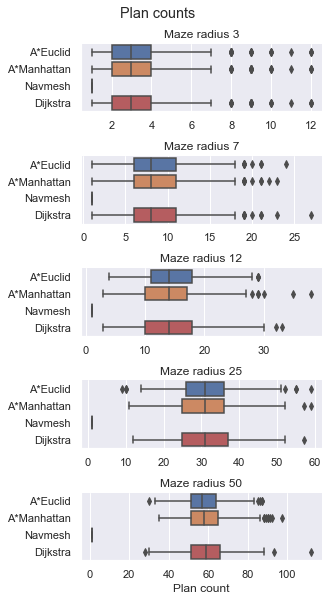

In [25]:
sns.set()
g = sns.catplot(y="agent",
                x="replan_count",
                row="maze_size",
                data = all_df.assign(maze_size=all_df.maze.str.extract(pat='-([0-9]{1,2})-').astype(int)),
                kind="box",
                sharex=False,
                height=1.7,
                aspect=2.9)
g.set_axis_labels("Plan count", "")
g.set_titles("Maze radius {row_name}")
plt.subplots_adjust(top=0.92)
g.fig.suptitle("Plan counts")
plt.savefig("plan_count.pdf")

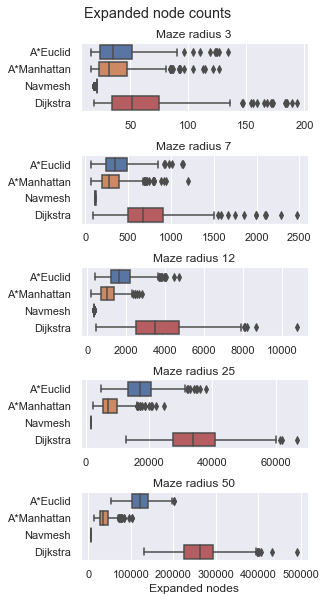

In [26]:
sns.set()
g = sns.catplot(y="agent",
                x="expanded_nodes",
                row="maze_size",
                data = all_df.assign(maze_size=all_df.maze.str.extract(pat='-([0-9]{1,2})-').astype(int)),
                kind="box",
                sharex=False,
                height=1.7,
                aspect=2.9)
g.set_axis_labels("Expanded nodes", "")
g.set_titles("Maze radius {row_name}")
plt.subplots_adjust(top=0.92)
g.fig.suptitle("Expanded node counts")
plt.savefig("expanded_nodes.pdf")

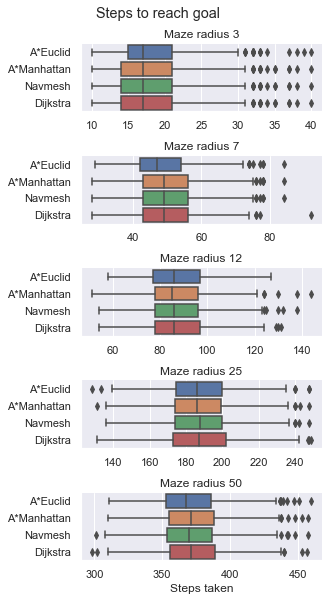

In [27]:
sns.set()
g = sns.catplot(y="agent",
                x="steps_taken",
                row="maze_size",
                data = all_df.assign(maze_size=all_df.maze.str.extract(pat='-([0-9]{1,2})-').astype(int)),
                kind="box",
                sharex=False,
                height=1.7,
                aspect=2.9)
g.set_axis_labels("Steps taken", "")
g.set_titles("Maze radius {row_name}")
plt.subplots_adjust(top=0.92)
g.fig.suptitle("Steps to reach goal")
plt.savefig("steps_taken.pdf")

In [28]:
all_df.assign(maze_size=all_df.maze.str.extract(pat='-([0-9]{1,2})-').astype(int))\
    .query("replan_count < 30 and agent != 'Navmesh' and maze_size > 25")

,maze,agent,optimal_steps,steps_taken,expanded_nodes,replan_count,maze_size
4827,maze-50-2,Dijkstra,204,314,144943,28,50


In [29]:
all_df.query("optimal_steps == steps_taken")

,maze,agent,optimal_steps,steps_taken,expanded_nodes,replan_count
3115,maze-3-1,A*Euclid,10,10,16,1
3156,maze-3-1,A*Euclid,10,10,23,2
3157,maze-3-1,A*Euclid,10,10,16,1
3323,maze-3-2,Dijkstra,10,10,38,2
3350,maze-3-2,Dijkstra,10,10,35,2
3353,maze-3-2,Dijkstra,10,10,21,1
3356,maze-3-2,Dijkstra,10,10,21,1
3423,maze-3-2,A*Euclid,10,10,24,2
3451,maze-3-2,A*Euclid,10,10,23,2
3454,maze-3-2,A*Euclid,10,10,18,1
